In [65]:
import pandas as pd

import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import random
import numpy as np
import scipy
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import pickle
from collections import Counter

import matplotlib.pyplot as plt

import sys

scripts_dir = '../scripts/'
sys.path.append(scripts_dir)
import IDseq_pathogen_functions2 
import IDSeq_plotting_functions_v2
import IDSeq_utility_functions

import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [66]:
output_directory = '080218_BN_1'
parameters = IDSeq_utility_functions.parse_params("./output/080218_BN_2/config.txt")



# Parse out the relevant features from Figure S1 - generated in main analysis above.
X = pd.read_csv("./output/080218_BN_2/microbe_data.csv", index_col = 0)

# look only at RNA-seq files (since this project contained both, this is an extra filtration step)
X = X[X['RNA'] == True]



In [67]:
def round_rpm(matrix):
    #X['log(NR_rpm)'] = np.round(X['log(NR_rpm)'])
    #X['perc_NR2'] = np.round(X['perc_NR2']*10)
    X['perc_NTr'] = np.round(X['perc_NTr']*100)
    X['perc_NRr'] = np.round(X['perc_NRr']*100)

#sqrt_value(X)
round_rpm(X)

In [68]:
pd.Series(parameters)

graph_axis                                          log(NT_rpm)
label                                           effective_group
model_parameters    [log(NT_rpm), reference_pathogen, perc_NT2]
negative_class                                             four
positive_class                                              one
training_set                                                 []
unknown_class                                     [three, five]
dtype: object

In [69]:
# Separate out by group membership for training and analysis of True Positive / True Negative
X_label_positive = X[X[parameters['label']] == parameters['positive_class']]
X_unk = pd.concat([X[X[parameters['label']] == i] for i in parameters['unknown_class']])

X_label_negative = X[X[parameters['label']] == parameters['negative_class']]
X_labelled = pd.concat([X_label_positive, X_label_negative], axis=0)

X_train = X_labelled[X_labelled['sampleID'].isin(parameters['training_set'])] 
X_test = X_labelled[~X_labelled['sampleID'].isin(parameters['training_set'])] 

# generate the outcome vectors based on whether microbe was identified by standard microbiology
Y_label_positive = X_label_positive['positive'].tolist()
Y_unk = X_unk['positive'].tolist()
Y_label_negative = X_label_negative['positive'].tolist()
Y_labelled = X_labelled['positive'].tolist()

y_train = list(X_train['positive'])

In [70]:
#lr = pickle.load( open( "/Users/kkalantar/Documents/Research/MBAL/miniBAL_study/output/042618/mBAL_g1g4combo_logRegModel", "rb" ) )
lr = pickle.load( open( "/Users/kkalantar/Desktop/pathoModel/build_model/output/080118_1/mBAL_g1g4combo_logRegModel", "rb" ) )
training_variables = ['log(genus_NR_rpm)','reference_pathogen','perc_NRr'] #['log(NT_rpm)','reference_pathogen','perc_NTr']
PROBABILITY_THRESHOLD = .25


print("LRM Model Coefficients for final pathogen v. commensal trained model:")
print(training_variables)
print(lr.coef_)


LRM Model Coefficients for final pathogen v. commensal trained model:
['log(genus_NR_rpm)', 'reference_pathogen', 'perc_NRr']
[[0.99090906 4.80905947 0.13565222]]


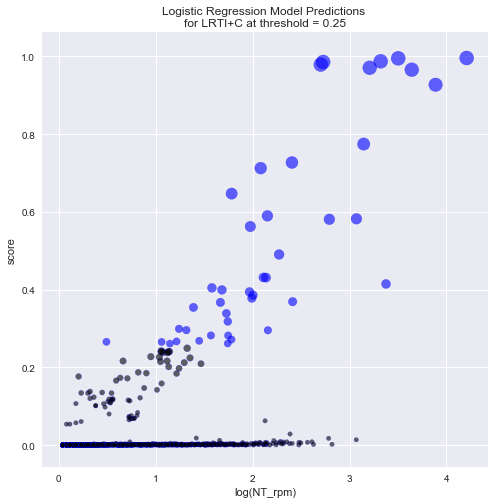

In [71]:

#
# TRAIN ON ALL TEST SAMPLES FOR BOTH PATHOGEN V. COMMENSAL MODEL AND PATIENT MICROBE MODEL
#

c = ['blue','red'] # for G1 and G4 projection plot 
                   # (where some microbes were identified by clinical microbiology)
c2 = ['blue','red'] # for G2 and G3 projection pplots



annotate_plots = False 
c = ['blue','blue']

# Plot predicted probabilities for group 2 patients' microbes
predicted = lr.predict_proba(X[training_variables])

X['score'] = predicted[:,1]

plt.figure(figsize=[8,8])
plt.scatter(X[parameters['graph_axis']],X['score'],
            edgecolor=[c[int(i)] for i in X['score']],
            s=[max(i*200,20) for i in X['score']],
            facecolor=[c[int(X['positive'][i])] if X['score'][i] > 
                       PROBABILITY_THRESHOLD else 'none' for i in range(len(X.index)) ],alpha=.6) 

plt.title("Logistic Regression Model Predictions \nfor LRTI+C at threshold = " + 
          str(PROBABILITY_THRESHOLD))
plt.xlabel(parameters['graph_axis'])
plt.ylabel('score')
plt.savefig('./output/' + output_directory + '/FigureS3B.pdf')


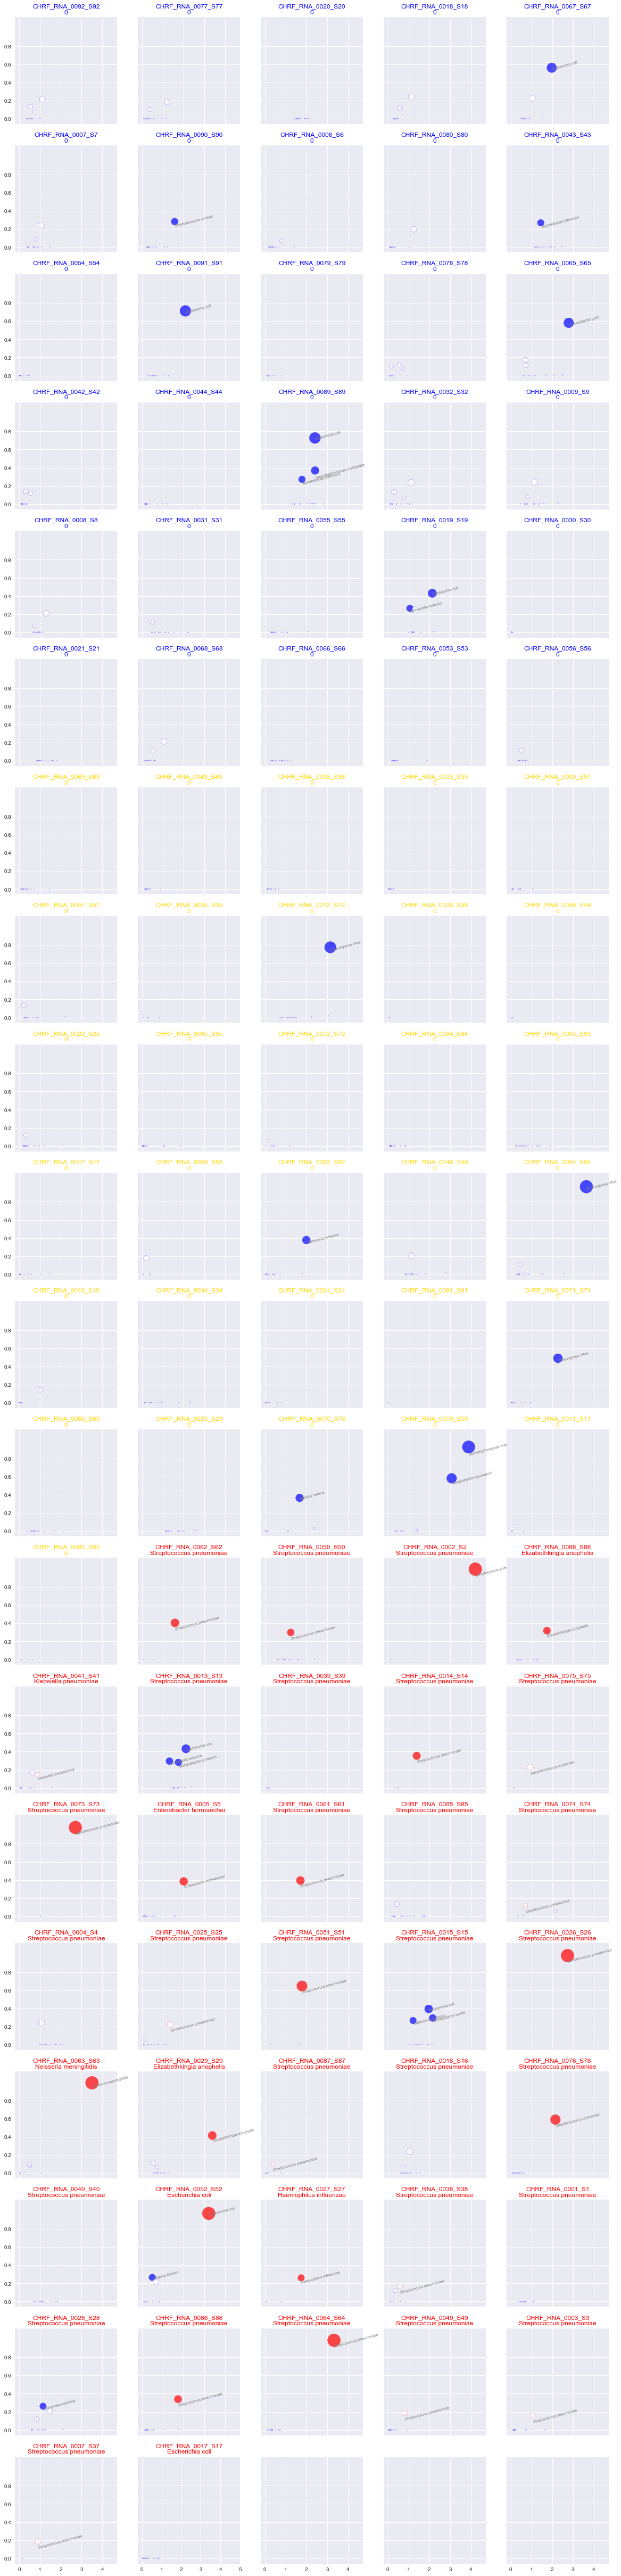

In [72]:
#print("TRAINING RESULTS")
IDSeq_plotting_functions_v2.per_sample_result_plots_sorted(X, './output/' + output_directory + '/Investigate_Train.pdf', 20, PROBABILITY_THRESHOLD, parameters['graph_axis'], parameters['label'], parameters['positive_class'],parameters['negative_class'],parameters['unknown_class'])


#print("TRAINING RESULTS")
#IDSeq_plotting_functions_v2.per_sample_result_plots(X_train, './output/' + output_directory + '/Investigate_Train.pdf', 4, PROBABILITY_THRESHOLD, parameters['graph_axis'])

#print("\nTEST RESULTS")
#IDSeq_plotting_functions_v2.per_sample_result_plots(X_test, './output/' + output_directory + '/Investigate_Test.pdf', 5, PROBABILITY_THRESHOLD, parameters['graph_axis'])

#print("\nGROUP 2 RESULTS")
#IDSeq_plotting_functions_v2.per_sample_result_plots(X_unk, './output/' + output_directory + '/Investigate_G2.pdf', 10, PROBABILITY_THRESHOLD, parameters['graph_axis'])

#print("\nGROUP 3 RESULTS")
#IDSeq_plotting_functions_v2.per_sample_result_plots(X_g3, './output/' + output_directory + '/Investigate_G3.pdf', 3, PROBABILITY_THRESHOLD, paramters['graph_axis'])

In [73]:
X[X['sampleID'] == 'CHRF_RNA_0059_S59']

,tax_id,name,common_name,tax_level,species_taxid,genus_taxid,family_taxid,category_name,is_phage,NT_r,...,log(genus_NT_rpm),perc_NRr,perc_NTr,perc_genus_NRr,perc_genus_NTr,RNA,perc_NR2,perc_NT2,is_virus,score
722,40324,Stenotrophomonas maltophilia,0,1,40324,40323,32033,Bacteria,0,516322.0,...,3.991638,13.0,38.0,0.275812,0.481058,True,0.633020,0.856538,False,0.926906
723,470,Acinetobacter baumannii,0,1,470,469,468,Bacteria,0,78643.0,...,3.510800,2.0,6.0,0.052226,0.158955,True,0.100262,0.130463,False,0.582268
724,68887,Torque teno virus,0,1,68887,-200687329,687329,Viruses,0,1759.0,...,1.439333,0.0,0.0,0.001494,0.001301,True,0.007471,0.002918,True,0.001901
725,307658,Monomorium pharaonis,pharaoh ant,1,307658,55077,36668,Eukaryota,0,1702.0,...,1.423246,0.0,0.0,0.000258,0.001249,True,0.001288,0.002823,False,0.000952
726,346,Xanthomonas citri,0,1,346,338,32033,Bacteria,0,1682.0,...,1.968483,5.0,0.0,0.063912,0.004511,True,0.253432,0.002790,False,0.018286
727,75702,Populus euphratica,Euphrates poplar,1,75702,3689,3688,Eukaryota,0,1163.0,...,1.264818,0.0,0.0,0.000043,0.000854,True,0.000209,0.001929,False,0.000568
728,687344,Torque teno virus 5,0,1,687344,687331,687329,Viruses,0,353.0,...,1.086360,0.0,0.0,0.000559,0.000551,True,0.002048,0.000586,True,0.001273
729,3659,Cucumis sativus,cucumber,1,3659,3655,3650,Eukaryota,0,260.0,...,0.934498,0.0,0.0,0.000026,0.000371,True,0.000015,0.000431,False,0.000513
730,1398,Bacillus coagulans,0,1,1398,1386,186817,Bacteria,0,244.0,...,1.012837,0.0,0.0,0.000336,0.000458,True,0.000356,0.000405,False,0.001049
731,86188,[Pseudomonas] geniculata,0,1,86188,-200032033,32033,Bacteria,0,192.0,...,2.313445,0.0,0.0,0.013013,0.010047,True,0.001438,0.000319,False,0.004749


In [74]:

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

gcombos = []

# TRYING TO CREATE COMBO HEATMAP THAT WILL TAKE IN THE INPUTS FROM ALL G1, G4, G2/3 and output the color-coded heatmap
# NOVEMBER 27

def create_prediction_heatmap_combo_overlap(input_rbm_data, input_lr_data, original_matrix, filename, groupID, true_classification, output_directory, metadata, training_sample_names, output_filename, print_output = False, collapse=True, diversity = None, DIVERSITY_THRESHOLD=1):

    input_rbm_data.to_csv('./output/' + output_directory + '/TableS6A.csv')
    input_lr_data.to_csv('./output/' + output_directory + '/TableS6B.csv')

    # new colors - using shade to indicate group, color to indicate clin +
    # WHITE, RB only (light blue), clin only (light grey), RB + Clin (light red), LR only (med blue), LR + RM (dark blue), LR + Clin (med red), LR + RB + Clin (dark red)
    colors = ['white',
              '#AFECFF',
              'lightgrey',
              '#FFA2A2',
              '#0BAEFF',
              '#0026B2',
              '#FF3232',
              '#C00000',
             'red','white','gold','blue','grey'] # trying to make the above colors more distinct

    CustomCmap = matplotlib.colors.ListedColormap(colors)
    yay_v = 0

    d = pd.DataFrame(0, index=np.arange(len(set(input_lr_data['microbe']))), columns=[i.split('.')[0].lower()+'.report.csv' for i in list(set(original_matrix['patient']))])
    d.index = set(input_lr_data['microbe'])
    #print(d)

    #loop through every patient and create a new column for each patient
    #add all group 1s
    g1s_train = []
    g1s_test = []
    for i in true_classification.index:
        if 'RNA' in i:
            if true_classification.loc[i]['effective_group'] == 1:
                if(i.lower()+'.report.csv' in training_sample_names):
                    g1s_train.append(i.lower()+'.report.csv')
                else:
                    g1s_test.append(i.lower()+'.report.csv')
                #g1s.append(i+'.report.csv')
                if i.lower() + '.report.csv' not in list(d.columns):   #if patient not in heatmap, add it.
                    d[i.lower() + '.report.csv'] = [0 for j in range(len(d.index))]
    #add all group 4s
    g4s_train = []
    g4s_test = []
    for i in true_classification.index:
        if 'RNA' in i:
            if true_classification.loc[i]['effective_group'] == 4:
                if(i.lower()+'.report.csv' in training_sample_names):
                    g4s_train.append(i.lower()+'.report.csv')
                else:
                    g4s_test.append(i.lower()+'.report.csv')
                #g4s.append(i+'.report.csv')
                if i.lower() + '.report.csv' not in list(d.columns):   #if patient not in heatmap, add it.
                    d[i.lower() + '.report.csv'] = [0 for j in range(len(d.index))]
    #add all group 2s
    g2s = []
    for i in true_classification.index:
        if 'RNA' in i:
            if true_classification.loc[i]['effective_group'] == 2:
                g2s.append(i.lower()+'.report.csv')
                if i.lower() + '.report.csv' not in list(d.columns):   #if patient not in heatmap, add it.
                    d[i.lower() + '.report.csv'] = [0 for j in range(len(d.index))]
    #add all group 3s
    g3s = []
    for i in true_classification.index:
        if 'RNA' in i:
            if true_classification.loc[i]['effective_group'] == 3:
                g3s.append(i.lower()+'.report.csv')
                if i.lower() + '.report.csv' not in list(d.columns):   #if patient not in heatmap, add it.
                    d[i.lower() + '.report.csv'] = [0 for j in range(len(d.index))]

    #add all group 5s
    g5s = []
    for i in true_classification.index:
        if 'RNA' in i:
            if true_classification.loc[i]['effective_group'] == 5:
                g5s.append(i.lower()+'.report.csv')
                if i.lower() + '.report.csv' not in list(d.columns):   #if patient not in heatmap, add it.
                    #print('HIIIIII')
                    d[i.lower() + '.report.csv'] = [0 for j in range(len(d.index))]

    #print(metadata.head())
    #print(input_rbm_data['patient'].head())
    #print(metadata[metadata['sample_name_RNA'] == input_lr_data.iloc[i]['patient'].split('.')[0].upper()]['organism'].iloc[0])
    
    
    
    '''
    # ADD VALUES FOR RB method
    for i in input_rbm_data.index:
        print(input_rbm_data.iloc[i]['patient'].split('.')[0] + '.report.csv')
        print(input_rbm_data.iloc[i]['patient'].split('.')[0] + '.report.csv' in list(diversity.index))
        print(diversity.index)
        print(diversity.head())
        print(diversity.loc[input_rbm_data.iloc[i]['patient'].split('.')[0] + '.report.csv'])
        if diversity.loc[input_rbm_data.iloc[i]['patient'].split('.')[0] + '.report.csv']['input'] > DIVERSITY_THRESHOLD:
            d[input_rbm_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_rbm_data.iloc[i]['microbe']] = 1
            orgs = metadata[metadata['sample_name_RNA'] == input_rbm_data.iloc[i]['patient'].split('.')[0].upper()]['organism'].iloc[0]
            #print(orgs)
            if(type(orgs) == type('string')):
                if input_rbm_data.iloc[i]['microbe'] in orgs.split(','):
                    yay_v += 1
                    d[input_rbm_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_rbm_data.iloc[i]['microbe']] = d[input_rbm_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_rbm_data.iloc[i]['microbe']] + 2

    '''
    
        # ADD VALUES FOR LR method
    for i in input_lr_data.index:
        #print(i)
        #print(input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv')
        #print(input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv' in list(diversity.index))
        
        
        if diversity.loc[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'] > DIVERSITY_THRESHOLD:
        
            try:
                #print(d.columns)
                #print(input_lr_data.iloc[i]['patient'])
                #print(input_lr_data.iloc[i]['microbe'])
                d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_lr_data.iloc[i]['microbe']] = d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_lr_data.iloc[i]['microbe']] + 4   #try to just add to existing values
            except:
                #NEED TO ADD THE ROW
                new_index = [ v for v in d.index] + [input_lr_data.iloc[i]['microbe']]
                d.loc[len(d)]=[0 for i in range(len(d.columns))]
                d.index = new_index
                d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_lr_data.iloc[i]['microbe']] = 4   # if the value has not existed before, add to the dataframe

            orgs = metadata[metadata['sample_name_RNA'] == input_lr_data.iloc[i]['patient'].split('.')[0].upper()]['organism'].iloc[0]   # loop through all the organisms
            if(type(orgs) == type('string')):
                if input_lr_data.iloc[i]['microbe'] in orgs.split(','):
                    yay_v += 1
                    #print(d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_lr_data.iloc[i]['microbe']])
                    if d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_lr_data.iloc[i]['microbe']] not in [3,7]:  # if the organism is confirmed, but has not previously been clinically confirmed then...add clinical to it
                        d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_lr_data.iloc[i]['microbe']] = d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_lr_data.iloc[i]['microbe']] + 2

    # LOOP THROUGH AND ADD CLINICAL GENERA
    #print("???")
    #print(len(set(input_lr_data.index)))
    #print(metadata.shape)

    for i in metadata.index:#input_lr_data.index:
        #print(i)
        index = metadata.loc[i]['sample_name_RNA'].lower()+'.report.csv'
        #print(index)
        
        #print(metadata.loc[i]['organism'])
        #print()
        orgs = metadata.loc[i]['organism']#[metadata['sample_name_RNA'] == input_lr_data.iloc[i]['patient'].split('.')[0].upper()]['organism'].iloc[0]
        if(type(orgs) == type('string')):
            #print(input_lr_data.iloc[i]['patient'])
            #print(orgs)
            '''
            for o in orgs.split(','):
                #list_of_species = list(set(input_lr_data.loc[input_lr_data['microbe_genus']==o]['microbe']).union(set(input_lr_data.loc[input_lr_data['microbe_genus']==o]['microbe'])))
                list_of_species = list(set(input_lr_data.loc[input_lr_data['microbe']==o]['microbe']).union(set(input_lr_data.loc[input_lr_data['microbe']==o]['microbe'])))
                print(list_of_species)
                a_species_was_found = False
                for s in list_of_species:
                    if not a_species_was_found:
                        try:
                            if d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][s] > 0:
                                a_species_was_found = True
                        except:
                            continue

                #print(a_species_was_found)

                if not a_species_was_found:
                    if sum([int(o == v ) for v in  d.index]) > 0:
                        print(o)
                        print(i)
                        print(input_lr_data.head())
                        d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][o] = 2
                    else:
                        new_index = [ v for v in d.index] + [o]
                        d.loc[len(d)]=[0 for i in range(len(d.columns))]

                        d.index = new_index
                        d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][o] = 2

            '''
            for o in orgs.split(','):
                #print(o)
                try:
                    #print('indise Try')
                    #print(d[index][o])
                    if d[index][o] > 0:
                        a_species_was_found = True
                    else:
                        d[index][o] = 2
                except:
                    print('in except')
                    new_index = [ v for v in d.index] + [o]
                    d.loc[len(d)]=[0 for i in range(len(d.columns))]
                    d.index = new_index
                    d[index][o] = 2




    #gcombos = g1s_train + g1s_test + g4s_train +  g4s_test + g2s + g3s + g5s
    #print("GCOMBOS")
    #print(gcombos)
    gcombos = [i.split('/')[-1].split('.')[0] + '.report.csv' for i in ordered_list_of_files]
    
    d = d[gcombos] # this sorts the columns in order of [group1] [group4]

    #'''
    groupid_names = [i.split('/')[-1].split('.')[0].upper() for i in ordered_list_of_files]
    groupids = []
    for i in groupid_names:
        groupids.append(
            metadata[metadata['sample_name_RNA'] == i]['effective_group'][0] + 7
        )
    d.loc['A_Group ID'] = groupids
    print(groupids)
    #'''
    
    
    #reset names to remove .report.csv notation
    new_col_names = []
    for i in d.columns:
        new_col_names.append(i.split('.')[0])
    d.columns = new_col_names




    # Apply some collapsing for the indices
    if(collapse):
        strep_viridans_group = ['Streptococcus pseudopneumoniae ( 257758 )','Streptococcus sp. VT 162 ( 1419814 )',
                                'Streptococcus salivarius ( 1304 )','Streptococcus mitis ( 28037 )',
                                'Streptococcus pseudopneumoniae ( 257758 )','Streptococcus anginosus ( 1328 )']
        strep_preprocessed_names = []
        #print(d.index)
        for i in d.index:
            if(i in strep_viridans_group):
                strep_preprocessed_names.append('Streptococci viridans Group ( XXX )')
            elif('coronavirus' in i):
                strep_preprocessed_names.append('Human coronavirus species ( XXX )')
            else:
                strep_preprocessed_names.append(i)  # strep pneumo and strep genera (clinical) will be merged

        d.index = strep_preprocessed_names
        first_values = [' '.join(i.split(' ')[0:-4]) if i.count(' ') > 3 else ' '.join(i.split(' ')[0:-3]) for i in d.index]
        d.index = first_values


        for j in d.columns:
            for k in set(first_values):
                #print(k)
                l = list(d[j][d.index==k])
                #print(l)
                if 2 in l and 3 in l:
                    # this is bad - it will collapse incorrectly and appear the BM and LR matched (score = 5),
                    # when in reality it was a collapse of RB+Clin (3) and Clin+ (3) again - need to modify the cases post-hoc.
                    #print([3] + [0 for i in range(len(l)-1)])
                    d[j][d.index==k] = [3] + [0 for i in range(len(l)-1)]





        d = d.groupby(d.index).sum()

        post_mod_index = []  # MODIFICATIONS TO UPDATE NAME OF STREP AND STAPH TO BE CLEAR
        for i in d.index:
            if(i == 'Streptococcus'):
                post_mod_index.append('Streptococcus pneumoniae')
            elif(i == 'Staphylococcus'):
                post_mod_index.append('Staphylococcus aureus')
            elif(i == 'Human respiratory syncytial'):
                post_mod_index.append('Human RSV')
            else:
                post_mod_index.append(i)

        d.index = post_mod_index

    


    # sort the indices by alphabetical order
    new_d = d.sort_index(axis=0)
    d = new_d
    d = d[d.sum(axis=1) > 0]
    
    
    manual_sorting = ['A_Group ID',
               'Enterobacter hormaechei',
              'Klebsiella pneumoniae',
              'Elizabethkingia anophelis',
              'Escherichia coli',
              'Streptococcus pneumoniae',
              'Haemophilus influenzae',
              'Neisseria meningitidis',
              'Enterovirus B',
              'Mumps rubulavirus',
              'Chikungunya virus',
              'Mycobacterium tuberculosis',
              'Acinetobacter baumannii',
              'Stenotrophomonas maltophilia',
              'Bacillus cereus',
              'Salmonella enterica']
    
    d = d.loc[manual_sorting]
    
    new_columns = ['_'.join([c.split('_')[0],c.split('_')[2]]).upper() for c in d.columns]
    #new_cols_temp = ['TA-' + str(c.split('-')[1]) for c in d.columns]  #convert names to TA-XXX notation
    #new_columns = [i[0:6] for i in new_cols_temp]  #get rid of TRNA from the one sample that has weird naming convention
    print(new_columns)
    d.columns = new_columns




    fig_height = (d.shape[0]/4.8)*2
    #fig_width = d.shape[1]/4.8
    fig_width = (d.shape[1]/6.4)*2

    #d.to_csv('LRcombo.csv')

    if print_output:
        print(d.head())

    #colors = ['white','#4AA2B6','lightgrey','#04819E','#69DE56','#F93846','#1DD300','#F90012']
    #ordered_colors = ['white','lightgrey','deepskyblue','blue','yellow','gold','orange','red']

    cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))


    plt.figure(figsize=(fig_width,fig_height))
    #ax = sns.heatmap(d,cmap=CustomCmap,vmin=0,vmax=7,cbar=False)
    ax = sns.heatmap(d,cmap=cmap,vmin=0,vmax=12)#,row_colors='red')#,cbar=False)
    ax.hlines([i for i in range(len(d.index))], *ax.get_xlim(),lw=.4)
    ax.vlines([i for i in range(len(d.columns))], *ax.get_ylim(),lw=.4)
    ax.tick_params(labelsize=10)
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([i for i in range(len(colors))])
    colorbar.set_ticks([0,2,1,3,4,6,5,7])
    colorbar.set_ticklabels(['NA','Clin+','RB+','RB+,Clin+','LR+','LR+,Clin+','LR+,RB+','LR+,RB+,Clin+'])
    #colorbar.set_ticklabels(['NA','RB+','Clin+','RB+,Clin+','LR+','LR+,RB+','LR+,Clin+','LR+,RB+,Clin+'])

    plt.title( filename + ", by patient ID")
    plt.savefig('./output/' + output_directory + '/' + output_filename , bbox_inches='tight')

    return d



lr_results = pd.concat([ 
                        patient_by_microbe_predicted_g2]) #,patient_by_microbe_predicted_g4_test, 
lr_results.reset_index(inplace=True)
c = pd.concat([rbm_g1,rbm_g4,rbm_g2,rbm_g3])
c.reset_index(inplace=True)

X_full = pd.concat([X_g1,X_g4,X_g2,X_g3])

# this representation enables easy viewing of the overlap btwn clinical and predicted results
# unfortunately, the published TableS2 does not highlight this aspect of the data as well, 
# so I am maintaining this graphic here.
#
d = create_prediction_heatmap_combo_overlap(c,lr_results,X_full, 
                                            './output/' +  output_directory + 
                                              '/Combined Predictions -\n Leave Out One Patient per Iteration',
                                               [1,4,2,3],
                                                               true_classification[true_classification.index.notnull()], 
                                                               output_directory, 
                                                               metadata, 
                                                               training_sample_names,
                                                               'FigureS3_TrainTest.pdf', 
                                                               print_output = False, 
                                                               collapse=False,
                                                               diversity = log(rna_input['RNA_input']+1),
                                                                DIVERSITY_THRESHOLD = 1.4)# pd.concat([pd.Series(RNA_diversity),pd.Series(DNA_diversity)], axis=1).max(axis=1),
                                                               #DIVERSITY_THRESHOLD=.6)
print("DONE WITH THE FIRST HEATMAP")

d = create_prediction_heatmap_combo_overlap(c,lr_results,X_full, 
                                            './output/' +  output_directory + 
                                              '/Combined Predictions -\n Leave Out One Patient per Iteration',
                                               [1,4,2,3],
                                                               true_classification[true_classification.index.notnull()], 
                                                               output_directory, 
                                                               metadata, 
                                                               training_sample_names,
                                                               'FigureS3_TrainTest_nodivthresh.pdf', 
                                                               print_output = False, 
                                                               collapse=False,
                                            diversity = log(rna_input['RNA_input']+1),
                                            DIVERSITY_THRESHOLD = 0
                                           #diversity = pd.concat([pd.Series(RNA_diversity),pd.Series(DNA_diversity)], axis=1).mean(axis=1),
                                                               )

NameError: name 'patient_by_microbe_predicted_g2' is not defined